# Random Data Generator
## a. Univariate Gaussian data generator
- mean: $m$
- Variance: $s$
- handcraft gaussian distribution
    - **Box-Muller transform**
    - Ziggurat algorithm 
- np.random.uniform()


In [607]:

import numpy as np

def  univariate_Gaussian_data_generator(m,s):
    u1 = np.random.uniform(0,1)
    u2 = np.random.uniform(0,1)
    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    x = m + np.sqrt(s) * z
    return x

print(univariate_Gaussian_data_generator(1.2204925277612,0))



1.2204925277612


## b. Polynomial basis linear model data generator 

- $y = W^{T}\phi(x)+e$
- $n$ (basis number)
- $a$ 資料中的雜訊變異數$e$服從一個平均值為0，變異數為$a$的常態分佈  $e \sim N(0,a)$
- $w$ nx1

In [608]:
def polynomial_basis_linear_model_data_generator(n_basis, a, w):
    x = np.random.uniform(-1, 1) # x is uniformly distributed in [-1, 1]
    phi = np.array([x**i for i in range(n_basis)])
    noise = univariate_Gaussian_data_generator(0, a)
    y = np.dot(phi, w) + noise
    return x, y

# print(polynomial_basis_linear_model_data_generator(3, 0.1, [1, 2, 3]))

# Sequential Estimator

In [609]:
m = 3.0
s = 5.0

print("Data point source function: N({},{})".format(m, s))

def sequential_estimator(m, s, threshold=1e-3):
    mean = 0
    variance = 0
    num = 0
    M2 = 0.0

    while True:
        # if num == 0:
        #     x = 1.2204925277612
        # else:
        x = univariate_Gaussian_data_generator(m, s)
        print(f"Add data point: {x:.6f}")
        num += 1
        delta = x - mean
        mean += delta / num
        delta2 = x - mean
        M2 += delta * delta2
        if num > 1:
            variance = M2 / (num - 1) # sample variance
        else:
            variance = 0.0

        print(f"Mean = {mean:.15f}    Variance = {variance:.15f}")
        if num > 5000:
            print("Too many data points, stopping.")
            break


        if num > 10 and abs(mean - m) < threshold and abs(variance - s) < threshold:
            print(num)
            break




sequential_estimator(m, s)


Data point source function: N(3.0,5.0)
Add data point: 0.272627
Mean = 0.272626603639731    Variance = 0.000000000000000
Add data point: 5.332212
Mean = 2.802419335649233    Variance = 12.799702533856200
Add data point: 4.044259
Mean = 3.216365995459391    Variance = 6.913906778432060
Add data point: 1.883810
Mean = 2.883226966929883    Variance = 5.053197634939709
Add data point: 6.062008
Mean = 3.518983266660719    Variance = 5.810828589442004
Add data point: 5.022857
Mean = 3.769628841619237    Variance = 5.025602097031317
Add data point: -1.787211
Mean = 2.975794596449591    Variance = 8.599211409154522
Add data point: 5.153791
Mean = 3.248044132087106    Variance = 7.963711113656900
Add data point: 1.969011
Mean = 3.105929354441390    Variance = 7.150016714677409
Add data point: 5.498275
Mean = 3.345163916695612    Variance = 6.927902170816278
Add data point: 1.325808
Mean = 3.161586071751391    Variance = 6.605821030432658
Add data point: 4.114402
Mean = 3.240987369077327    Vari

# Bayesian Linear Regression

In [610]:
def predict(x_range, mu, S, n_basis, a):
    means = []
    stds = []
    for x in x_range:
        phi = np.array([x**i for i in range(n_basis)])
        mean = np.dot(mu, phi)
        var = 1/a + np.dot(phi, np.dot(S, phi))
        means.append(mean)
        stds.append(np.sqrt(var))
    return np.array(means), np.array(stds)

Add data point (-0.48757801056038796,-0.9764895245487524)

posterior mean:

-0.4454591868703214
0.1791363315120494
-0.07203763265732495
0.028969112379766612

posterior variance:

[ 0.5438157   0.18344931 -0.07377205  0.02966659]
[ 0.18344931  0.92622795  0.02966659 -0.01193008]
[-0.07377205  0.02966659  0.98806992  0.00479755]
[ 0.02966659 -0.01193008  0.00479755  0.99807072]

Predictive distribution ~ N(-0.53103, 1.54382)

Add data point (0.3077466680794194,2.286789119838334)

posterior mean:

0.46704852127020013
0.09452995126801778
-0.10848945356307867
0.06121873481813719

posterior variance:

[ 0.38211417  0.19844204 -0.06731258  0.02395177]
[ 0.19844204  0.92483785  0.02906768 -0.01140021]
[-0.06731258  0.02906768  0.98781188  0.00502583]
[ 0.02395177 -0.01140021  0.00502583  0.99786875]

Predictive distribution ~ N(0.43574, 1.33461)

Add data point (0.7520753388160359,3.8460205933888547)

posterior mean:

1.4094568164519916
0.970228419012165
-0.15125524229765702
0.1298407575940821

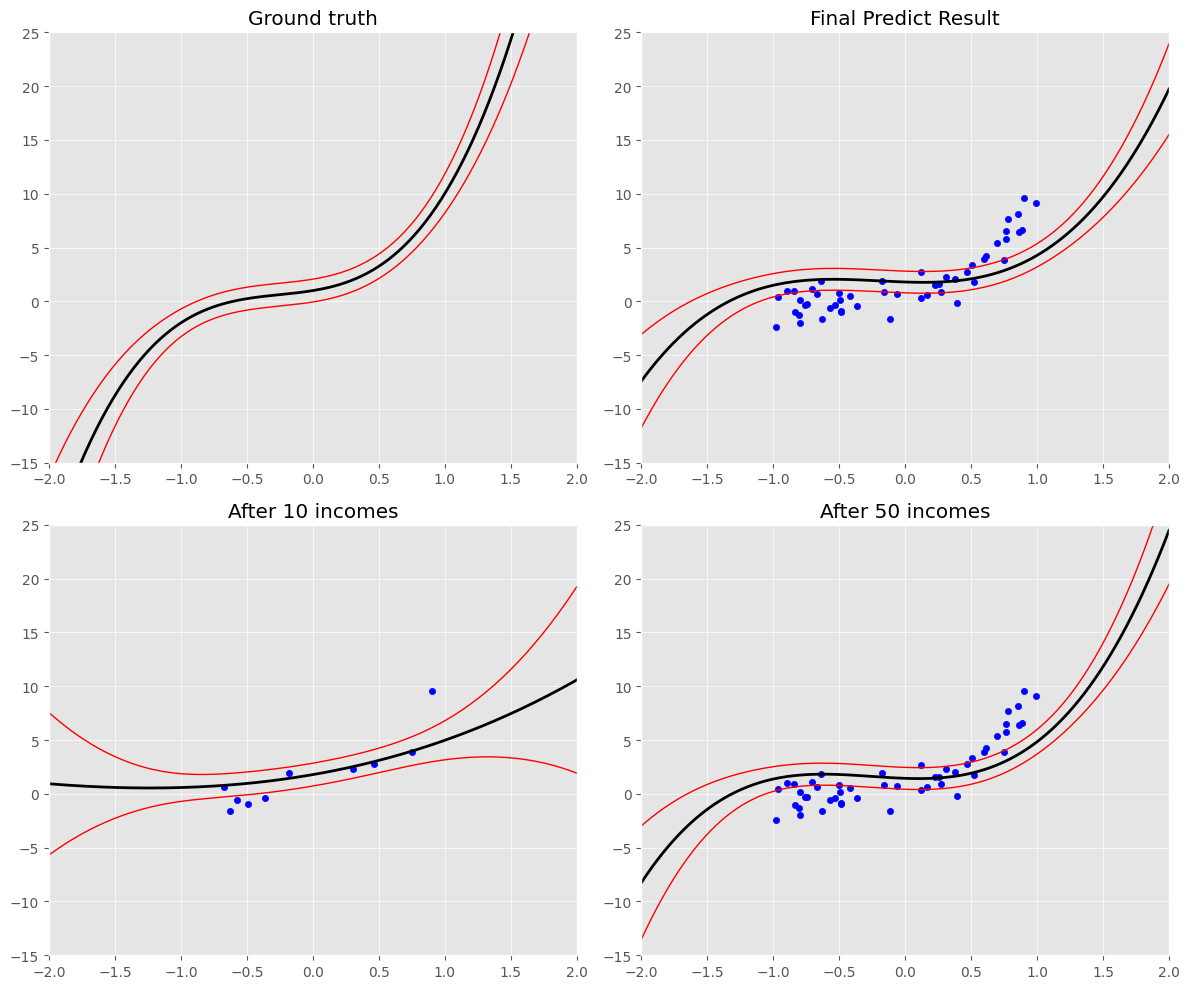

In [611]:
import matplotlib.pyplot as plt

def bayesian_learning(n_basis, a, w_true, b, steps, temp_steps=[10, 50]):
    S_inv = b * np.identity(n_basis)
    m = np.zeros(n_basis)

    x_seen = []
    y_seen = []

    temp = {}

    for t in range(steps):
        h = np.random.uniform(-1, 1)
        phi = np.array([h**i for i in range(n_basis)])
        x, y = polynomial_basis_linear_model_data_generator(n_basis, a, w_true)
        print("Add data point ({},{})\n".format(x, y))
        S_inv += (1 / a) * np.outer(phi, phi) #每筆資料帶來的資訊
        S = np.linalg.inv(S_inv) # 1
        m += (1 / a) * y * phi # 每筆資料對mean的影響
        mu_post = np.dot(S, m) # 2
        mu_pred = np.dot(mu_post, phi) # 用後驗的 w 來對新資料點進行預測
        sigma2_pred = 1 / a + np.dot(phi, np.dot(S, phi))

        print("posterior mean:\n")
        for g in mu_post:
            print(g)
        print("\nposterior variance:\n")
        for g in S:
            print(g)
        # print("\nposterior variance:\n")
        # for v in np.diag(S):
        #     print(v)
        print("\nPredictive distribution ~ N({:.5f}, {:.5f})\n".format(mu_pred, sigma2_pred))

        x_seen.append(x)
        y_seen.append(y)

        if (t + 1) in temp_steps:
            temp[t + 1] = {
                "mu": mu_post.copy(),
                "S": S.copy(),
                "x_seen": x_seen.copy(),
                "y_seen": y_seen.copy()
            }
    # Add final result
    temp["final"] = {
        "mu": mu_post.copy(),
        "S": S.copy(),
        "x_seen": x_seen.copy(),
        "y_seen": y_seen.copy()
    }

    return temp


def plot_bayes_snapshots(snapshots, n_basis, a, w_true):
    plt.style.use('ggplot')
    x_plot = np.linspace(-2, 2, 200)
    true_y = [np.dot(w_true, [x**i for i in range(n_basis)]) for x in x_plot]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # 使用第 10 筆 snapshot 資料作為 early prediction baseline
    snap_10 = snapshots[10]
    pred_mean_10, pred_std_10 = predict(x_plot, snap_10["mu"], snap_10["S"], n_basis, a)

    snap_50 = snapshots[50]
    pred_mean_50, pred_std_50 = predict(x_plot, snap_50["mu"], snap_50["S"], n_basis, a)

    final_snapshot = snapshots["final"]
    pred_mean_final, pred_std_final = predict(x_plot, final_snapshot["mu"], final_snapshot["S"], n_basis, a)

    # 左上：Ground truth
    axs[0, 0].plot(x_plot, true_y, 'k', label='Ground truth')
    axs[0, 0].plot(x_plot, np.array(true_y) + pred_std_10, 'r', linewidth=1)
    axs[0, 0].plot(x_plot, np.array(true_y) - pred_std_10, 'r', linewidth=1)
    axs[0, 0].set_xlim([-2, 2])
    axs[0, 0].set_ylim([-15, 25])
    axs[0, 0].set_title("Ground truth")


    # 右上：Final predict result
    axs[0, 1].plot(x_plot, pred_mean_final,'k',label='Predict mean')
    axs[0, 1].plot(x_plot, pred_mean_final + pred_std_final, 'r', linewidth=1)
    axs[0, 1].plot(x_plot, pred_mean_final - pred_std_final, 'r', linewidth=1)
    axs[0, 1].scatter(snap_50["x_seen"], snap_50["y_seen"], color='blue', s=20)
    axs[0, 1].set_xlim([-2, 2])
    axs[0, 1].set_ylim([-15, 25])
    axs[0, 1].set_title("Final Predict Result")

    # 左下：After 10 incomes
    axs[1, 0].plot(x_plot, pred_mean_10, 'black', label='Predict mean')
    axs[1, 0].plot(x_plot, pred_mean_10 + pred_std_10, 'r', linewidth=1)
    axs[1, 0].plot(x_plot, pred_mean_10 - pred_std_10, 'r', linewidth=1)
    axs[1, 0].scatter(snap_10["x_seen"], snap_10["y_seen"], color='blue', s=20)
    axs[1, 0].set_xlim([-2, 2])
    axs[1, 0].set_ylim([-15, 25])
    axs[1, 0].set_title("After 10 incomes")

    # 右下：After 50 incomes
    axs[1, 1].plot(x_plot, pred_mean_50, 'black', label='Predict mean')
    axs[1, 1].plot(x_plot, pred_mean_50 + pred_std_50, 'r', linewidth=1)
    axs[1, 1].plot(x_plot, pred_mean_50 - pred_std_50, 'r', linewidth=1)
    axs[1, 1].scatter(snap_50["x_seen"], snap_50["y_seen"], color='blue', s=20)
    axs[1, 1].set_xlim([-2, 2])
    axs[1, 1].set_ylim([-15, 25])
    axs[1, 1].set_title("After 50 incomes")

    plt.tight_layout()
    plt.show()


b = 1
n = 4
a = 1
w_true = np.array([1, 2, 3, 4])


temp = bayesian_learning(
    n_basis=n,
    a=a,
    w_true=w_true,
    b=b,
    steps=100

)

plot_bayes_snapshots(temp, n_basis=n, a=a, w_true=w_true)
